In [1]:
!pwd

/global/cfs/cdirs/m4334/jerry/climsim3_dev/evaluation/offline


In [2]:
import numpy as np
from sklearn.metrics import r2_score
import torch
import os, gc
from climsim_utils.data_utils import *
from tqdm import tqdm
from matplotlib import cm

In [3]:
input_path = '/global/homes/j/jerrylin/scratch/hugging/E3SM-MMF_ne4/preprocessing/v2_rh_mc/scoring_set/scoring_input.npy'
target_path = '/global/homes/j/jerrylin/scratch/hugging/E3SM-MMF_ne4/preprocessing/v2_rh_mc/scoring_set/scoring_target.npy'
preds_path = '/global/homes/j/jerrylin/scratch/hugging/E3SM-MMF_ne4/preprocessing/v2_rh_mc/scoring_set/preds/'

unet_path = '/global/homes/j/jerrylin/scratch/hugging/E3SM-MMF_ne4/saved_models/prelim_comparison/unet/model.pt'
squeezeformer_path = '/global/homes/j/jerrylin/scratch/hugging/E3SM-MMF_ne4/saved_models/prelim_comparison/squeezeformer/model.pt'
pure_resLSTM_path = '/global/homes/j/jerrylin/scratch/hugging/E3SM-MMF_ne4/saved_models/prelim_comparison/pure_resLSTM/model.pt'
pao_model_path = '/global/homes/j/jerrylin/scratch/hugging/E3SM-MMF_ne4/saved_models/prelim_comparison/pao_model/model.pt'
convnext_path = '/global/homes/j/jerrylin/scratch/hugging/E3SM-MMF_ne4/saved_models/prelim_comparison/convnext/model.pt'
encdec_lstm_path = '/global/homes/j/jerrylin/scratch/hugging/E3SM-MMF_ne4/saved_models/prelim_comparison/encdec_lstm/model.pt'

model_paths = {'unet': unet_path, \
               'squeezeformer': squeezeformer_path, \
               'pure_resLSTM': pure_resLSTM_path, \
               'pao_model': pao_model_path, \
               'convnext': convnext_path, \
               'encdec_lstm': encdec_lstm_path,
            }

model_colors = {'unet': 'green', \
                'squeezeformer': 'purple', \
                'pure_resLSTM': 'blue', \
                'pao_model': 'red', \
                'convnext': 'orange', \
                'encdec_lstm': 'brown'}

model_labels = {'unet': 'U-net', \
                'squeezeformer': 'Squeezeformer', \
                'pure_resLSTM': 'pure resLSTM', \
                'pao_model': 'Pao Model', \
                'convnext': 'ConvNeXt', \
                'encdec_lstm': 'Encoder-Decoder LSTM'
                }

num_models = len(model_paths)
model_preds = {}
r2_scores = {}
r2_scores_capped = {}
zonal_heating_r2 = {}
zonal_moistening_r2 = {}

input_mean_file = 'input_mean_v6_pervar.nc'
input_max_file = 'input_max_v6_pervar.nc'
input_min_file = 'input_min_v6_pervar.nc'
output_scale_file = 'output_scale_std_lowerthred_v6.nc'
lbd_qn_file = 'qn_exp_lambda_large.txt'

grid_path = '../../grid_info/ClimSim_low-res_grid-info.nc'

grid_info = xr.open_dataset(grid_path)
input_mean = xr.open_dataset('../../preprocessing/normalizations/inputs/' + input_mean_file)
input_max = xr.open_dataset('../../preprocessing/normalizations/inputs/' + input_max_file)
input_min = xr.open_dataset('../../preprocessing/normalizations/inputs/' + input_min_file)
output_scale = xr.open_dataset('../../preprocessing/normalizations/outputs/' + output_scale_file)
lbd_qn = np.loadtxt('../../preprocessing/normalizations/inputs/' + lbd_qn_file, delimiter = ',')

data = data_utils(grid_info = grid_info, 
                  input_mean = input_mean, 
                  input_max = input_max, 
                  input_min = input_min, 
                  output_scale = output_scale,
                  qinput_log = False,
                  normalize = False)
data.set_to_v2_rh_mc_vars()

input_sub, input_div, out_scale = data.save_norm(write=False) # this extracts only the relevant variables
input_sub = input_sub[None, :]
input_div = input_div[None, :]
out_scale = out_scale[None, :]

lat = grid_info['lat'].values
lon = grid_info['lon'].values
lat_bin_mids = data.lat_bin_mids

def preprocessing_v2_rh_mc(data, input_path, target_path):
    npy_input = np.load(input_path)
    npy_target = np.load(target_path)
    
    surface_pressure = npy_input[:, data.ps_index] * \
                        (input_max['state_ps'].values - input_min['state_ps'].values) + \
                        input_mean['state_ps'].values
    
    hyam_component = (data.hyam * data.p0)[np.newaxis,:]
    hybm_component = data.hybm[np.newaxis,:] * surface_pressure[:, np.newaxis]
    
    pressures = hyam_component + hybm_component
    pressures = pressures.reshape(-1,384,60)
    
    pressures_binned = data.zonal_bin_weight_3d(pressures)
    
    npy_input[:,120:180] = 1 - np.exp(-npy_input[:,120:180] * lbd_qn)
    npy_input = (npy_input - input_sub)/input_div
    npy_input = np.where(np.isnan(npy_input), 0, npy_input)
    npy_input = np.where(np.isinf(npy_input), 0, npy_input)
    npy_input[:,120:120+15] = 0
    npy_input[:,60:120] = np.clip(npy_input[:,60:120], 0, 1.2)
    torch_input = torch.tensor(npy_input).float()
    reshaped_target = npy_target.reshape(-1, data.num_latlon, data.target_feature_len)
    return torch_input, reshaped_target, pressures_binned

torch_input, reshaped_target, pressures_binned = preprocessing_v2_rh_mc(data, input_path, target_path)

assert torch_input.shape[0] == reshaped_target.shape[0] * reshaped_target.shape[1]
assert torch_input.shape[0] % data.num_latlon == 0

for model_name in model_paths.keys():
    model_preds[model_name] = np.load(preds_path + f'{model_name}_preds.npy')

def show_r2(target, preds):
    assert target.shape == preds.shape, f'target shape {target.shape} does not match preds shape {preds.shape}'
    new_shape = (np.prod(target.shape[:-1]), target.shape[-1])
    target_flattened = target.reshape(new_shape)
    preds_flattened = preds.reshape(new_shape)
    r2_scores = np.array([r2_score(target_flattened[:, i], preds_flattened[:, i]) for i in range(308)])
    r2_scores_capped = r2_scores.copy()
    r2_scores_capped[r2_scores_capped < 0] = 0
    return r2_scores, r2_scores_capped

for model_name in model_paths.keys():
    r2_scores[model_name], r2_scores_capped[model_name] = show_r2(reshaped_target, model_preds[model_name])
    
mean_r2_single = np.mean([np.mean(r2_scores[model_name]) for model_name in model_paths.keys()])
mean_r2_all = np.mean([r2_scores[model_name] for model_name in model_paths.keys()], axis = 0)

def get_coeff(target, pred):
    rss = np.sum((pred - target)**2, axis = 0)
    tss = np.sum((target - np.mean(target, axis = 0)[None,:,:])**2, axis = 0)
    coeff = 1 - rss/tss
    mask = tss == 0
    coeff[mask] = 1.0 * (rss[mask] == 0) 
    return coeff

for model_name in model_paths.keys():
    zonal_heating_r2[model_name] = data.zonal_bin_weight_3d(get_coeff(reshaped_target[:,:,:60], \
                                                                      model_preds[model_name][:,:,:60]))[0]
    zonal_moistening_r2[model_name] = data.zonal_bin_weight_3d(get_coeff(reshaped_target[:,:,60:120], \
                                                                          model_preds[model_name][:,:,60:120]))[0]

zonal_heating_r2_avg = np.mean([zonal_heating_r2[model_name] for model_name in model_paths.keys()], axis = 0)
zonal_moistening_r2_avg = np.mean([zonal_moistening_r2[model_name] for model_name in model_paths.keys()], axis = 0)

/tmp/ipykernel_114167/2877362926.py:92: RuntimeWarning: divide by zero encountered in divide
  npy_input = (npy_input - input_sub)/input_div
/tmp/ipykernel_114167/2877362926.py:128: RuntimeWarning: invalid value encountered in divide
  coeff = 1 - rss/tss


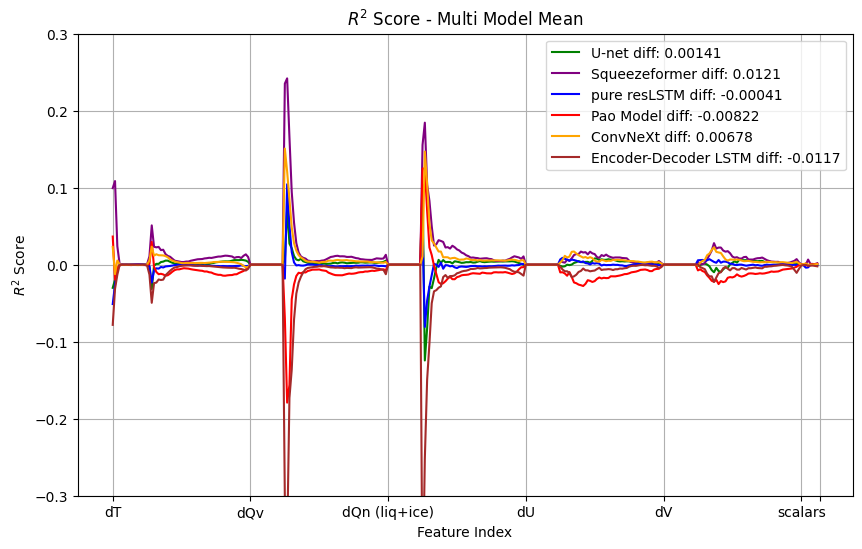

In [4]:
plt.figure(figsize=(10, 6))
for model_name in model_paths.keys():
    label_text = f'{model_labels[model_name]} diff: {np.mean(r2_scores[model_name]) - mean_r2_single:.3g}' 
    plt.plot(np.arange(data.target_feature_len), r2_scores[model_name] - mean_r2_all, color = model_colors[model_name], label=f"{label_text}")
    
plt.legend()
plt.xlabel('Feature Index')
plt.ylabel(r'$R^2$ Score')
plt.title(r'$R^2$ Score - Multi Model Mean')

feature_indices = [0, 60, 120, 180, 240, 300, 308]
feature_labels = ['dT', 'dQv', 'dQn (liq+ice)', 'dU', 'dV', 'scalars', '']
plt.xticks(ticks=feature_indices, labels=feature_labels)
plt.ylim(-.3, .3)
plt.grid(True)

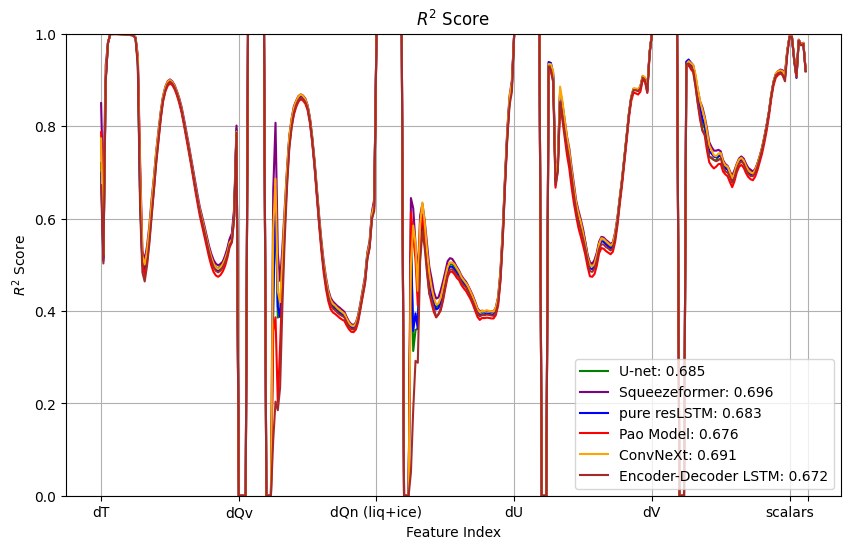

In [5]:
plt.figure(figsize=(10, 6))
for model_name in model_paths.keys():
    label_text = f'{model_labels[model_name]}: {np.mean(r2_scores[model_name]):.3g}' 
    plt.plot(np.arange(data.target_feature_len), r2_scores[model_name], color = model_colors[model_name], label=f"{label_text}")
    
plt.legend()
plt.xlabel('Feature Index')
plt.ylabel(r'$R^2$ Score')
plt.title(r'$R^2$ Score')

feature_indices = [0, 60, 120, 180, 240, 300, 308]
feature_labels = ['dT', 'dQv', 'dQn (liq+ice)', 'dU', 'dV', 'scalars', '']
plt.xticks(ticks=feature_indices, labels=feature_labels)
plt.ylim(0, 1)
plt.grid(True)

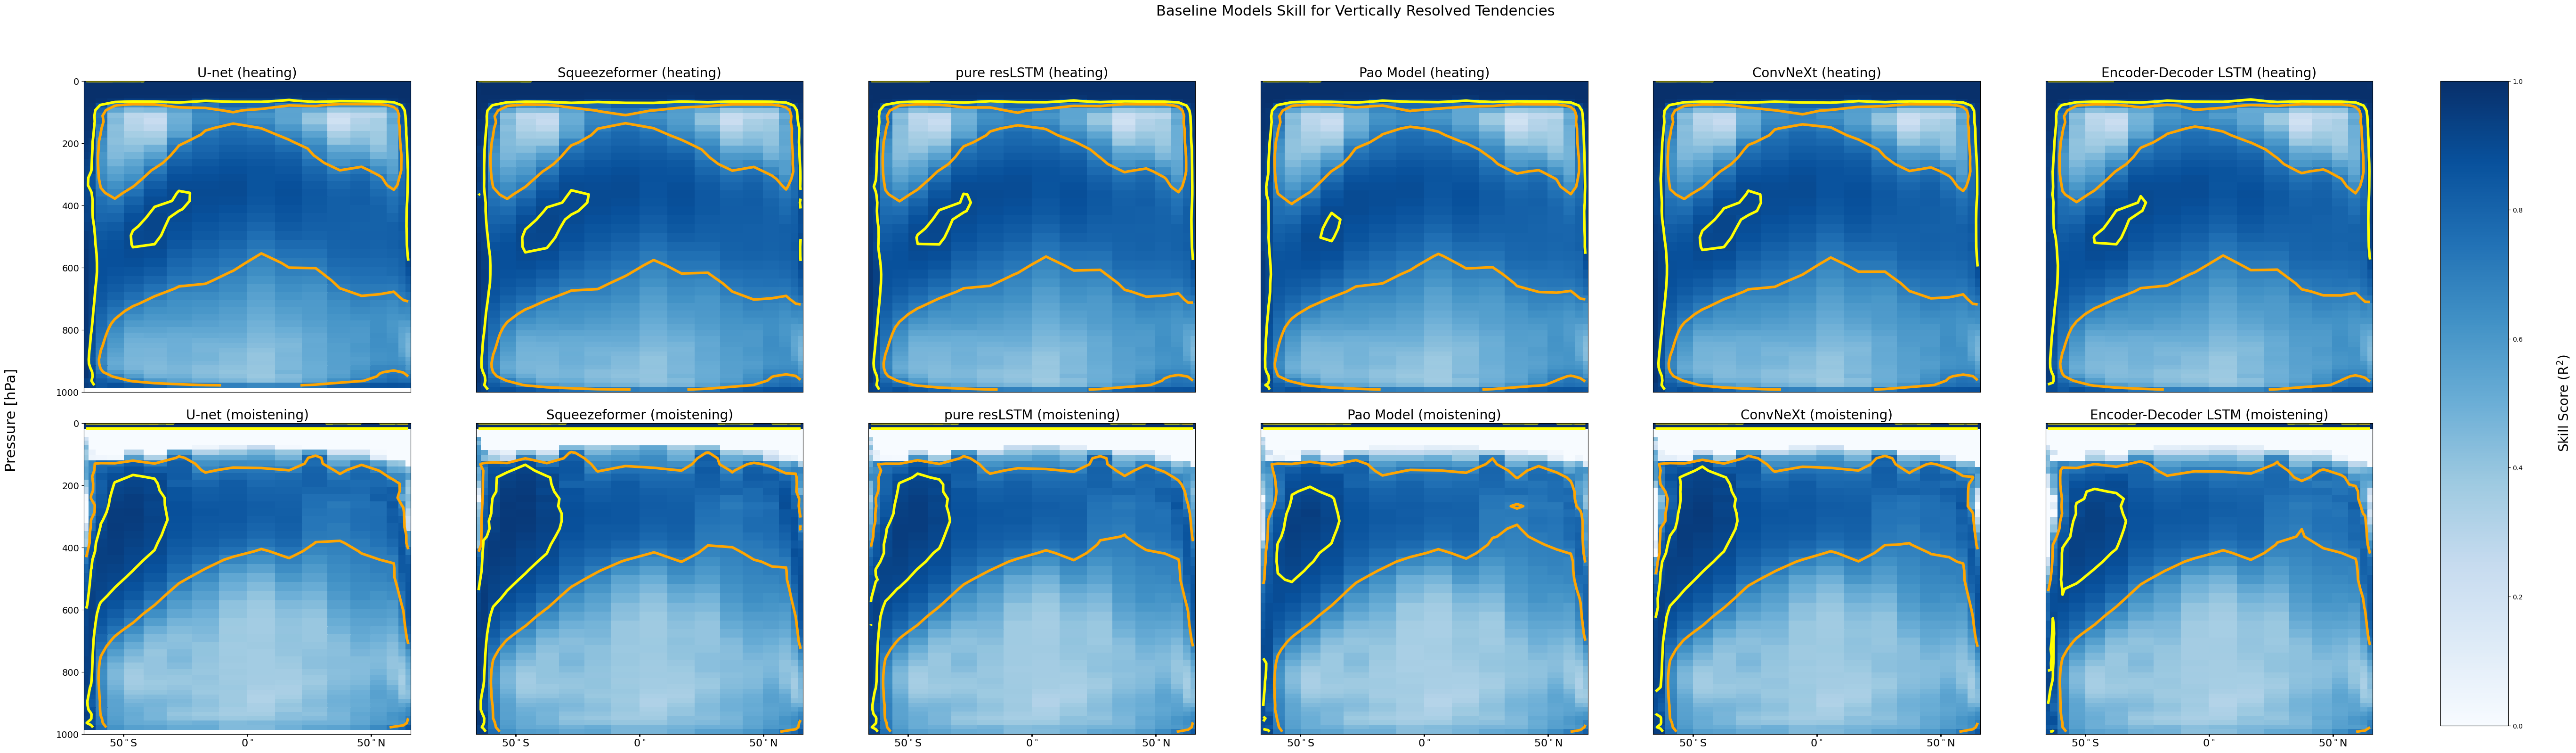

In [6]:
fig, ax = plt.subplots(2, num_models, figsize = (num_models*12, 18))
y = np.arange(60)
X, Y = np.meshgrid(np.sin(np.pi*lat_bin_mids/180), y)
Y = (1/100) * np.mean(pressures_binned, axis = 0).T
for i, model_name in enumerate(model_paths.keys()):
    contour_plot_heating = ax[0,i].pcolor(X, Y, zonal_heating_r2[model_name].T, cmap='Blues', vmin = 0, vmax = 1)
    ax[0,i].contour(X, Y, zonal_heating_r2[model_name].T, [0.7], colors='orange', linewidths=[4])
    ax[0,i].contour(X, Y, zonal_heating_r2[model_name].T, [0.9], colors='yellow', linewidths=[4])
    ax[0,i].set_ylim(ax[0,i].get_ylim()[::-1])
    ax[0,i].set_title(f'{model_labels[model_name]} (heating)', fontsize = 20)
    ax[0,i].set_xticks([])
    contour_plot = ax[1,i].pcolor(X, Y, zonal_moistening_r2[model_name].T, cmap='Blues', vmin = 0, vmax = 1) # pcolormesh
    ax[1,i].contour(X, Y, zonal_moistening_r2[model_name].T, [0.7], colors='orange', linewidths=[4])
    ax[1,i].contour(X, Y, zonal_moistening_r2[model_name].T, [0.9], colors='yellow', linewidths=[4])
    ax[1,i].set_ylim(ax[1,i].get_ylim()[::-1])
    ax[1,i].set_title(f'{model_labels[model_name]} (moistening)', fontsize = 20)
    ax[1,i].xaxis.set_ticks([np.sin(-50/180*np.pi), 0, np.sin(50/180*np.pi)])
    ax[1,i].xaxis.set_ticklabels(['50$^\circ$S', '0$^\circ$', '50$^\circ$N'], fontsize = 16)
    ax[1,i].xaxis.set_tick_params(width = 2)
    if i != 0:
        ax[0,i].set_yticks([])
        ax[1,i].set_yticks([])
ax[0,0].set_ylabel("Pressure [hPa]", fontsize = 22)
ax[0,0].yaxis.set_label_coords(-0.2,-0.09) # (-1.38,-0.09)
ax[0,0].yaxis.set_tick_params(labelsize = 14)
ax[1,0].yaxis.set_tick_params(labelsize = 14)
ax[0,0].yaxis.set_ticks([1000,800,600,400,200,0])
ax[1,0].yaxis.set_ticks([1000,800,600,400,200,0])
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.12, 0.02, 0.76])
cb = fig.colorbar(contour_plot, cax=cbar_ax)
cb.set_label("Skill Score "+r'$\left(\mathrm{R^{2}}\right)$',labelpad=50.1, fontsize = 20)
plt.suptitle("Baseline Models Skill for Vertically Resolved Tendencies", y = 0.97, fontsize = 22)
plt.subplots_adjust(hspace=0.1)

/tmp/ipykernel_114167/3368918310.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  reversed_cmap = cm.get_cmap('seismic').reversed()


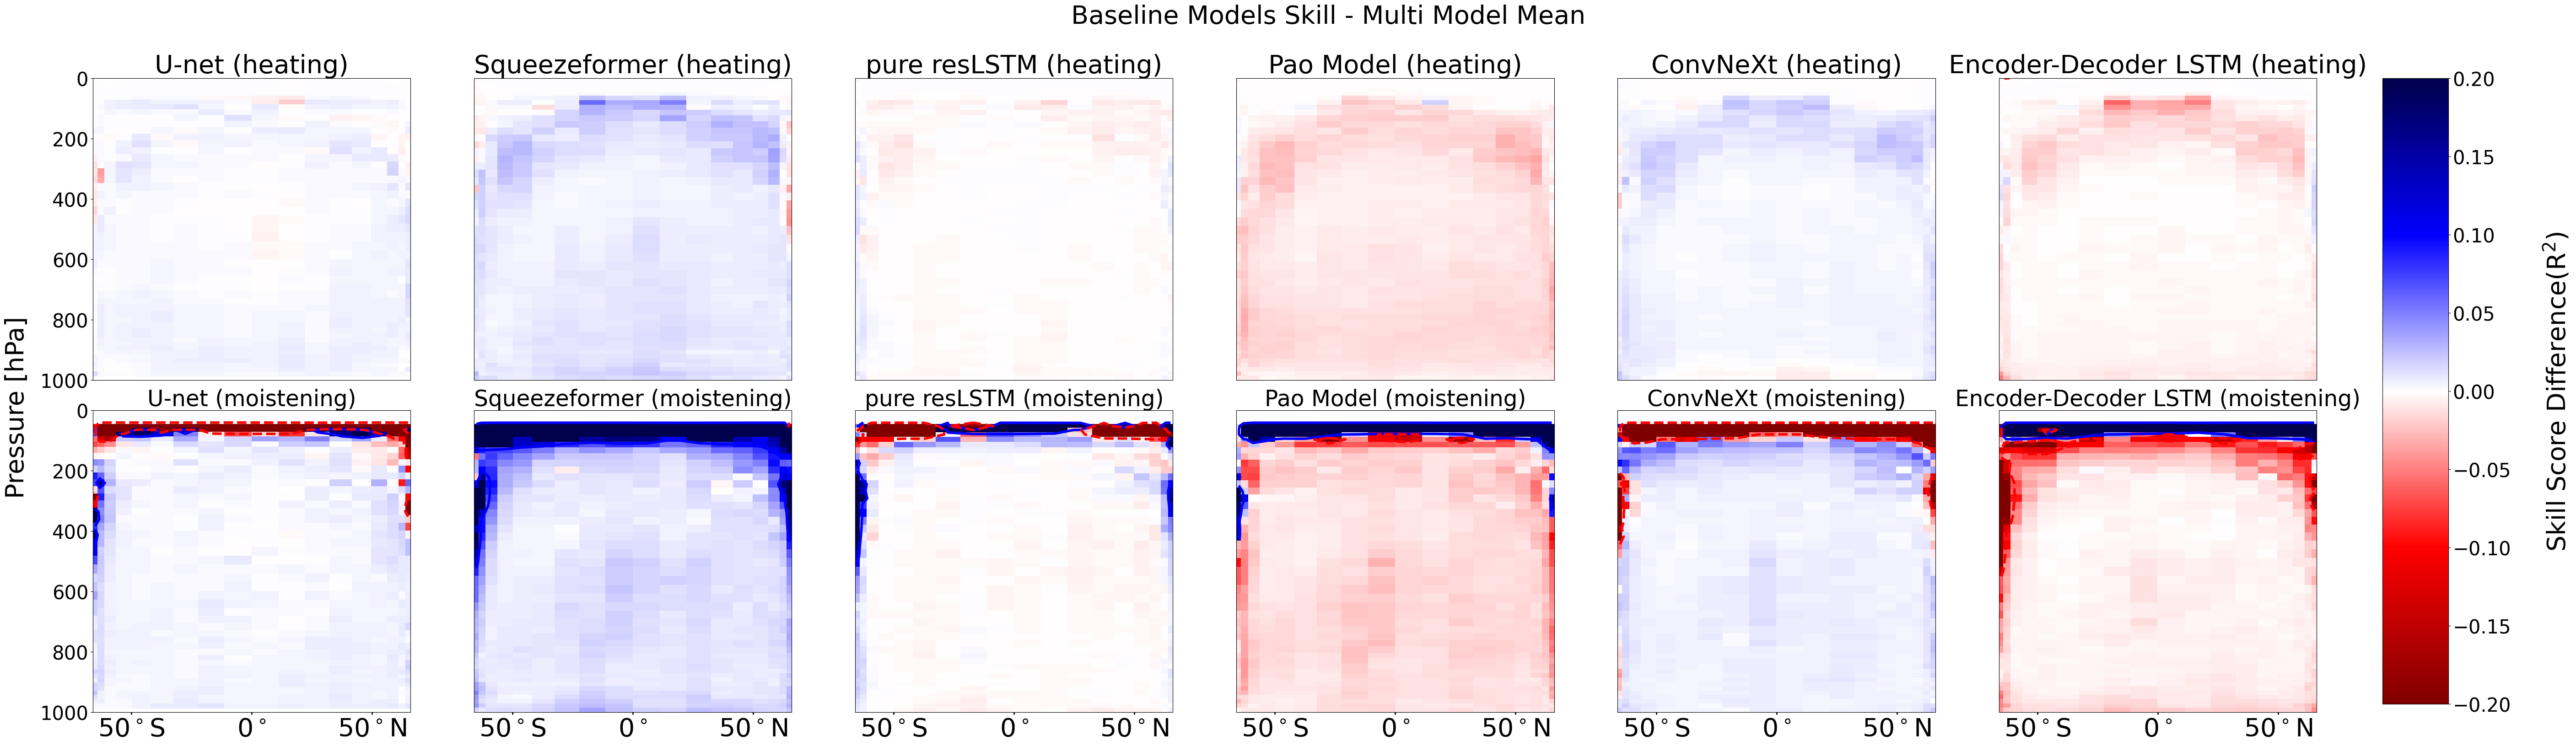

In [18]:
fig, ax = plt.subplots(2, num_models, figsize = (num_models*12, 18))
y = np.arange(60)
X, Y = np.meshgrid(np.sin(np.pi*lat_bin_mids/180), y)
Y = (1/100) * np.mean(pressures_binned, axis = 0).T
reversed_cmap = cm.get_cmap('seismic').reversed()
for i, model_name in enumerate(model_paths.keys()):
    zonal_heating_r2_diff = (zonal_heating_r2[model_name] - zonal_heating_r2_avg).T
    zonal_moistening_r2_diff = (zonal_moistening_r2[model_name] - zonal_moistening_r2_avg).T
    contour_plot_heating = ax[0,i].pcolor(X, Y, zonal_heating_r2_diff, cmap=reversed_cmap, vmin = -.2, vmax = .2)
    ax[0,i].contour(X, Y, zonal_heating_r2_diff, [0.1], colors='blue', linewidths=[4])
    ax[0,i].contour(X, Y, zonal_heating_r2_diff, [-0.1], colors='red', linewidths=[4])
    ax[0,i].set_ylim(ax[0,i].get_ylim()[::-1])
    ax[0,i].set_title(f'{model_labels[model_name]} (heating)', fontsize = 40)
    ax[0,i].set_xticks([])
    contour_plot = ax[1,i].pcolor(X, Y, zonal_moistening_r2_diff, cmap=reversed_cmap, vmin = -.2, vmax = .2) # pcolormesh
    ax[1,i].contour(X, Y, zonal_moistening_r2_diff, [0.1], colors='blue', linewidths=[4])
    ax[1,i].contour(X, Y, zonal_moistening_r2_diff, [-0.1], colors='red', linewidths=[4])
    ax[1,i].set_ylim(ax[1,i].get_ylim()[::-1])
    ax[1,i].set_title(f'{model_labels[model_name]} (moistening)', fontsize = 35)
    ax[1,i].xaxis.set_ticks([np.sin(-50/180*np.pi), 0, np.sin(50/180*np.pi)])
    ax[1,i].xaxis.set_ticklabels(['50$^\circ$S', '0$^\circ$', '50$^\circ$N'], fontsize = 40)
    ax[1,i].xaxis.set_tick_params(width = 2)
    if i != 0:
        ax[0,i].set_yticks([])
        ax[1,i].set_yticks([])
ax[0,0].set_ylabel("Pressure [hPa]", fontsize = 40)
ax[0,0].yaxis.set_label_coords(-0.2,-0.09) # (-1.38,-0.09)
ax[0,0].yaxis.set_tick_params(labelsize = 30)
ax[1,0].yaxis.set_tick_params(labelsize = 30)
ax[0,0].yaxis.set_ticks([1000,800,600,400,200,0])
ax[1,0].yaxis.set_ticks([1000,800,600,400,200,0])
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.12, 0.02, 0.76])
cbar_ax.tick_params(labelsize=30)
cb = fig.colorbar(contour_plot, cax=cbar_ax)
cb.set_label("Skill Score Difference"+r'$\left(\mathrm{R^{2}}\right)$',labelpad=50.1, fontsize = 40)
plt.suptitle("Baseline Models Skill - Multi Model Mean", y = 0.97, fontsize = 40)
plt.subplots_adjust(hspace=0.1)